We will use the make_classification() scikit-learn function to define a synthetic binary (2-class) classification task with 100 input features (columns) and 1,000 examples (rows). Importantly, we will define the problem in such a way that most of the input variables are redundant (90 of the 100 or 90 percent), allowing the autoencoder later to learn a useful compressed representation.

In [1]:
# synthetic classification dataset
from sklearn.datasets import make_classification
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# summarize the dataset
print(X.shape, y.shape)

(1000, 100) (1000,)


In [2]:
# split into train test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

We will define the encoder to have two hidden layers, the first with two times the number of inputs (e.g. 200) and the second with the same number of inputs (100), followed by the bottleneck layer with the same number of inputs as the dataset (100 uncompressed) or reduced number of nodes representing filtered bottleneck(50). To ensure the model learns well, we will use batch normalization and leaky ReLU activation.

In [3]:
# define encoder
from keras.layers import Input, Dense, LeakyReLU 
from keras.layers.normalization import BatchNormalization

n_inputs = X.shape[1]
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
#n_bottleneck = n_inputs # no compression of bottleneck
n_bottleneck = round(float(n_inputs) / 2.0) # reduced nodes to 50
bottleneck = Dense(n_bottleneck)(e)

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-10-04 21:51:25.960862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-04 21:51:25.960975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The decoder will be defined with a similar structure, although in reverse. It will have two hidden layers, the first with the number of inputs in the dataset (e.g. 100) and the second with double the number of inputs (e.g. 200). The output layer will have the same number of nodes as there are columns in the input data and will use a linear activation function to output numeric values.

In [4]:
# define decoder, level 1
from keras.models import Model, load_model
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
ae_model = Model(inputs=visible, outputs=output)

The model will be fit using the efficient Adam version of stochastic gradient descent and minimizes the mean squared error, given that reconstruction is a type of multi-output regression problem.

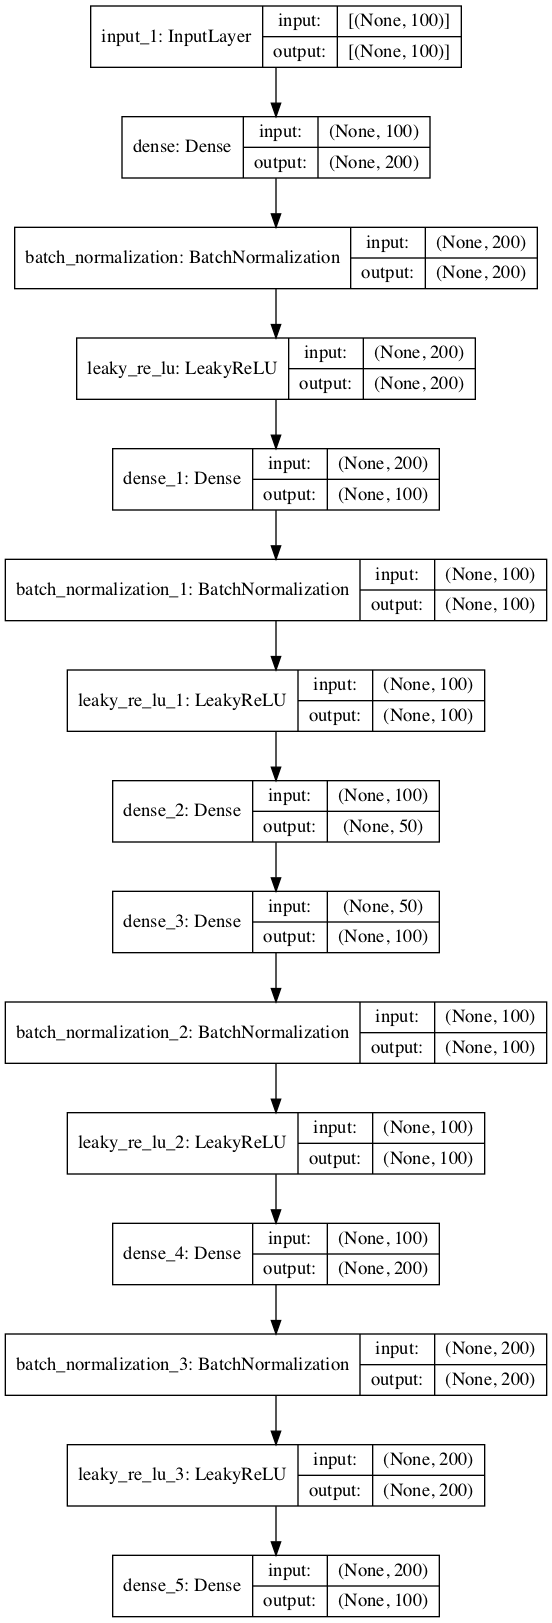

In [5]:
# compile autoencoder model
ae_model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
from keras.utils.vis_utils import plot_model
plot_model(ae_model, 'autoencoder_compress.png', show_shapes=True)

Next, we can train the model to reproduce the input and keep track of the performance of the model on the hold-out test set.

In [6]:
# fit the autoencoder model to reconstruct input
history = ae_model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test, X_test))

2021-10-04 21:51:26.833409: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-04 21:51:26.833832: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/200


2021-10-04 21:51:33.970487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/42 - 8s - loss: 0.2400 - val_loss: 0.1814


2021-10-04 21:51:35.007606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 2/200
42/42 - 1s - loss: 0.0358 - val_loss: 0.1147
Epoch 3/200
42/42 - 1s - loss: 0.0225 - val_loss: 0.0575
Epoch 4/200
42/42 - 1s - loss: 0.0194 - val_loss: 0.0329
Epoch 5/200
42/42 - 1s - loss: 0.0166 - val_loss: 0.0191
Epoch 6/200
42/42 - 1s - loss: 0.0150 - val_loss: 0.0139
Epoch 7/200
42/42 - 1s - loss: 0.0122 - val_loss: 0.0104
Epoch 8/200
42/42 - 1s - loss: 0.0128 - val_loss: 0.0089
Epoch 9/200
42/42 - 1s - loss: 0.0122 - val_loss: 0.0086
Epoch 10/200
42/42 - 1s - loss: 0.0108 - val_loss: 0.0062
Epoch 11/200
42/42 - 1s - loss: 0.0104 - val_loss: 0.0059
Epoch 12/200
42/42 - 1s - loss: 0.0100 - val_loss: 0.0079
Epoch 13/200
42/42 - 1s - loss: 0.0108 - val_loss: 0.0070
Epoch 14/200
42/42 - 1s - loss: 0.0096 - val_loss: 0.0049
Epoch 15/200
42/42 - 1s - loss: 0.0093 - val_loss: 0.0076
Epoch 16/200
42/42 - 1s - loss: 0.0087 - val_loss: 0.0050
Epoch 17/200
42/42 - 1s - loss: 0.0077 - val_loss: 0.0048
Epoch 18/200
42/42 - 1s - loss: 0.0077 - val_loss: 0.0047
Epoch 19/200
42/42 - 1

In [7]:
X_train_pred = ae_model.predict(X_train)

2021-10-04 21:53:45.192362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [8]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)
# mae is mean absolute error
mae_vector = get_error_term(X_train_pred, X_train, _rmse=False)
rmse_vector = get_error_term(X_train_pred, X_train, _rmse=True)
reconstr_error_vector = [e ** 2 for e in rmse_vector]
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
#print(f'Reconstructive_MSE_vector: {reconstr_error_vector} ')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.02636135839713924
median error 0.024735003472523262
99Q: 0.053268160722946774
setting threshold on 0.053268160722946774 


In [9]:
X_pred = ae_model.predict(X_test)
mae_vector = get_error_term(X_pred, X_test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

0.012121212121212121

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, anomalies))

              precision    recall  f1-score   support

           0       0.51      0.98      0.67       170
           1       0.00      0.00      0.00       160

    accuracy                           0.50       330
   macro avg       0.25      0.49      0.33       330
weighted avg       0.26      0.50      0.34       330



In [11]:
X_pred.shape

(330, 100)

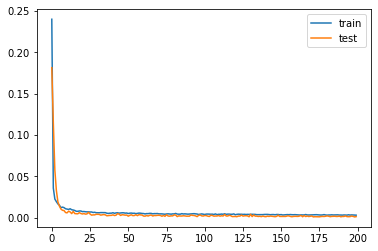

In [12]:
# plot loss

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In this section, we will use the trained encoder from the autoencoder to compress input data and train a different predictive model. First, let’s establish a baseline in performance on this problem. This is important as if the performance of a model is not improved by the compressed encoding, then the compressed encoding does not add value to the project and should not be used. We can train a logistic regression model on the training dataset directly and evaluate the performance of the model on the holdout test set.

In [13]:
# baseline in performance with logistic regression model
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define model
model = LogisticRegression()
# fit model on training set
model.fit(X_train, y_train)
# make prediction on test set
yhat = model.predict(X_test)
# calculate accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.8939393939393939


We would hope and expect that a logistic regression model fit on the same input plus information from encoding to achieve better accuracy for the encoding to be considered useful. We can update the input data with an additional column of RMSE values generated using the encoder model trained in the previous section.

In [14]:
import math
reconstr_error = ae_model.evaluate(X_train, X_train, verbose=0)
print('The reconstruction error: %.4f MSE (%.4f RMSE)' % (reconstr_error , math.sqrt(reconstr_error )))

The reconstruction error: 0.0012 MSE (0.0343 RMSE)


In [15]:
X_test_pred = ae_model.predict(X_test)
test_rmse_vector = get_error_term(X_test_pred, X_test, _rmse=True)
test_reconstr_error_vector = [e ** 2 for e in test_rmse_vector]
test_max = max(test_reconstr_error_vector)
test_max

0.00986176222591052

In [16]:
#We can then add this reconstr_mse from autoencoding to the training dataset and evaluate the logistic regression model.
X_train_label = np.concatenate((X_train, np.array([reconstr_error_vector]).T), axis=1)
X_test_label = np.concatenate((X_test, np.array([test_reconstr_error_vector]).T), axis=1)
#print(X_train_label[:,100])
label_array = np.append(reconstr_error_vector, test_reconstr_error_vector, axis=None)
max_label = max(label_array)
print(X_train_label.shape, X_test_label.shape, max_label)
X_train_label[:,100] = 100 * X_train_label[:,100]/max_label
X_test_label[:,100] = 100 * X_test_label[:,100]/max_label
print(X_train_label[100])
# define the model
model = LogisticRegression(max_iter=2000)
# fit the model on the training set
model.fit(X_train_label, y_train)
# make predictions on the test set
yhat = model.predict(X_test_label)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

(670, 101) (330, 101) 0.00986176222591052
[0.57266594 0.44005731 0.39794605 0.46893785 0.36722291 0.6172641
 0.29982815 0.4747984  0.25025843 0.63628414 0.49415016 0.37607636
 0.33875445 0.52933708 0.252291   0.33870625 0.64430836 0.40023435
 0.58218859 0.5713132  0.26227508 0.33772406 0.4811073  0.53776773
 0.11602454 0.21067177 0.42624082 0.50203253 0.11245242 0.45371842
 0.61101199 0.24878658 0.45524193 0.13456472 0.65792953 0.7342741
 0.3723817  0.5155472  0.22197866 0.48769406 0.38737196 0.42859259
 0.73480171 0.38454938 0.57715725 0.49634774 0.41837388 0.54199222
 0.51870399 0.64096193 0.32210767 0.65614664 0.60323087 0.72973967
 0.55445693 0.31624253 0.3643006  0.2275032  0.24144432 0.62846741
 0.42967289 0.49559251 0.26087725 0.6458773  0.3807451  0.51817568
 0.42152552 0.62720277 0.44787223 0.585554   0.7740674  0.29848116
 0.79704509 0.45281245 0.71099578 0.61897586 0.5897401  0.67021218
 0.27490302 0.43900139 0.80783208 0.25038374 0.61204512 0.71865206
 0.40684622 0.43486849

We can see that adding autoencoder rmse labels to train and test sets would improve the logistic regression slightly

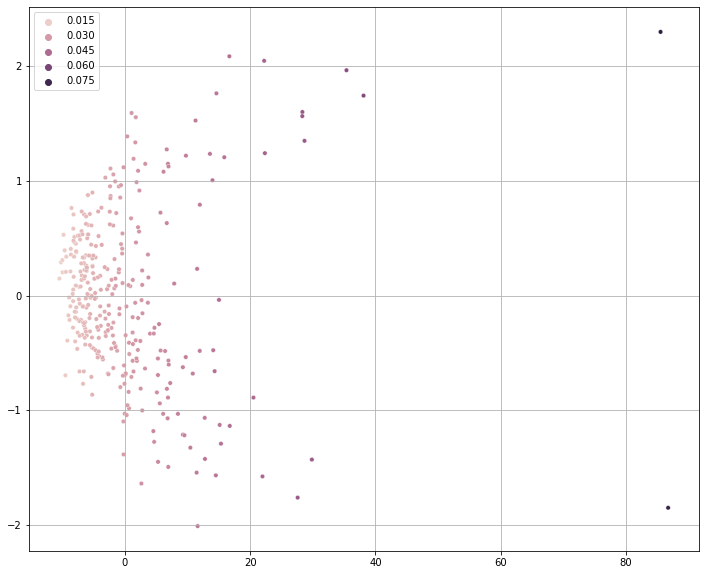

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_test_label)
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

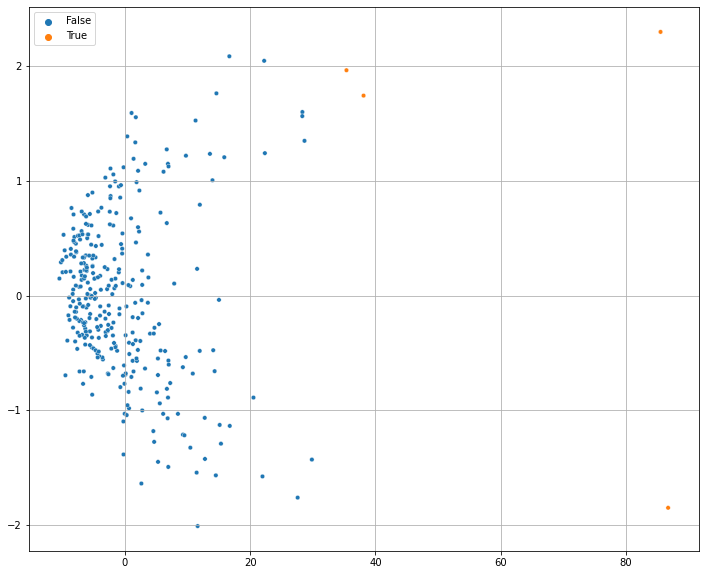

In [18]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

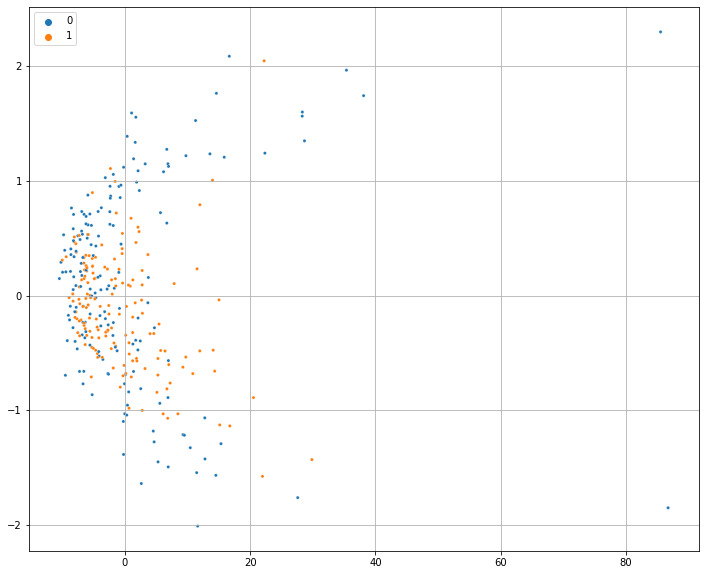

In [19]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=y_test)
plt.grid()
plt.show()

In this section, we will use the RMSE from the autoencoder to add aditional label onto input data and train an another predictive model. Gradient Boosting Machines Regression. Gradient Boosting to produce a predictive model from an ensemble of weak predictive models. Gradient boosting can be used for regression and classification problems. We can train a GBM regressor on the training dataset directly and evaluate the performance of the model on the holdout test set. Decision trees are used as the weak learners in gradient boosting. Decision Tree solves the problem of machine learning by transforming the data into tree representation. Each internal node of the tree representation denotes an attribute and each leaf node denotes a class label. The loss function is generally the squared error (particularly for regression problems). The loss function needs to be differentiable.

In [20]:
# baseline in performance with GBM regressor
from sklearn import ensemble
# define model
params = {'n_estimators': 200,
          'max_depth': 4,
          'min_samples_split': 6,
          'min_samples_leaf': 1,
          'learning_rate': 0.1,
          'subsample': 0.4,          
          'loss': 'ls'}
gbm_regressor = ensemble.GradientBoostingRegressor(**params, random_state=1)
# fit model on training set
gbm_regressor.fit(X_train, y_train)
# make prediction on test set
yhat = gbm_regressor.predict(X_test)
#rounted_yhat = np.rint(np.array(yhat))
rounded_yhat = np.around(yhat)
rounded_yhat = rounded_yhat.astype(int)
#rounded_yhat=np.argmax(yhat, axis=0)
#print(rounded_yhat)
# calculate accuracy
acc = accuracy_score(y_test, rounded_yhat)
print("The accuracy score (acc) on test set: {:.4f}".format(acc))

The accuracy score (acc) on test set: 0.9394


In the 1999 paper “Greedy Function Approximation: A Gradient Boosting Machine“, Jerome Friedman comments on the trade-off between the number of trees (M) and the learning rate (v):

The v-M trade-off is clearly evident; smaller values of v give rise to larger optimal M-values. They also provide higher accuracy, with a diminishing return for v < 0.125. The misclassification error rate is very flat for M > 200, so that optimal M-values for it are unstable. …  the qualitative nature of these results is fairly universal.

He suggests to first set a large value for the number of trees, then tune the shrinkage parameter to achieve the best results. Studies in the paper preferred a shrinkage value of 0.1, a number of trees in the range 100 to 500 and the number of terminal nodes in a tree between 2 and 8. A tree depth of 3 (if the created tree was symmetrical) will have 8 leaf nodes, matching the upper bound of the preferred number of terminal nodes in Friedman’s studies (alternately max_leaf_nodes can be set). max_leaf_nodes=k gives comparable results to max_depth=k-1 but is significantly faster to train at the expense of a slightly higher training error.

In the 1999 paper “Stochastic Gradient Boosting“, Friedman reiterated the preference for the shrinkage parameter:

The “shrinkage” parameter 0 < v < 1 controls the learning rate of the procedure. Empirically …, it was found that small values (v <= 0.1) lead to much better generalization error.

The size of the regression tree base learners defines the level of variable interactions that can be captured by the gradient boosting model. In general, a tree of depth h can capture interactions of order h . There are two ways in which the size of the individual regression trees can be controlled.

If you specify max_depth=h then complete binary trees of depth h will be grown. Such trees will have (at most) 2**h leaf nodes and 2**h - 1 split nodes.

Alternatively, you can control the tree size by specifying the number of leaf nodes via the parameter max_leaf_nodes. In this case, trees will be grown using best-first search where nodes with the highest improvement in impurity will be expanded first. A tree with max_leaf_nodes=k has k - 1 split nodes and thus can model interactions of up to order max_leaf_nodes - 1 .

We found that max_leaf_nodes=k gives comparable results to max_depth=k-1 but is significantly faster to train at the expense of a slightly higher training error. The parameter max_leaf_nodes corresponds to the variable J in the chapter on gradient boosting in [F2001] and is related to the parameter interaction

The accuracy score (acc) on test set: 0.9273


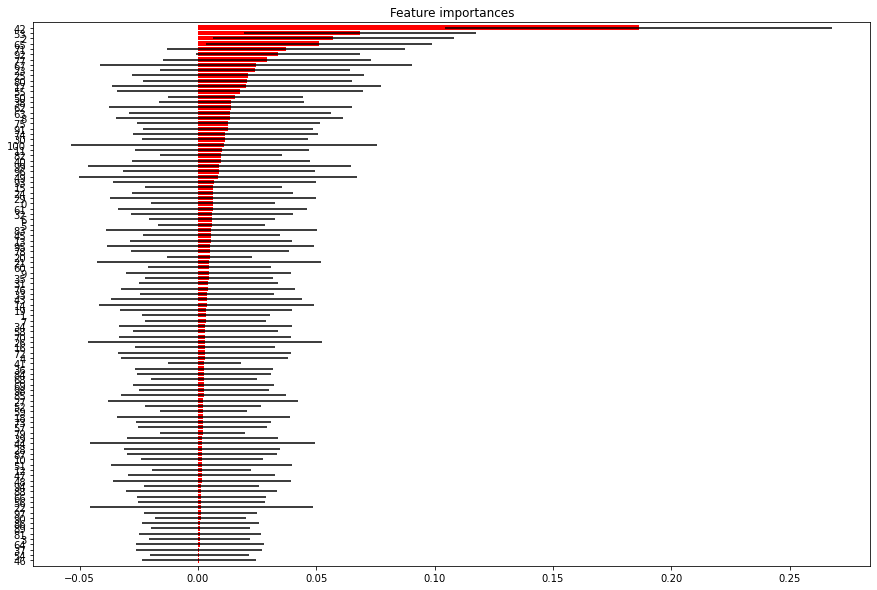

In [21]:
#We can then use this encoded data to train and evaluate the GBM regression model, as before.
gbm_regressor = ensemble.GradientBoostingRegressor(**params, random_state=1)
# fit model on training set
gbm_regressor.fit(X_train_label, y_train)
# make prediction on test set
yhat = gbm_regressor.predict(X_test_label)
#rounted_yhat = np.rint(np.array(yhat))
rounded_yhat = np.around(yhat)
rounded_yhat = rounded_yhat.astype(int)
# calculate accuracy
acc = accuracy_score(y_test, rounded_yhat)
print("The accuracy score (acc) on test set: {:.4f}".format(acc))
importances = gbm_regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in np.ravel(gbm_regressor.estimators_)],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.barh(range(X_train_label.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train_label.shape[1]), indices)
plt.ylim([-1, X_train_label.shape[1]])
plt.show()

Improvement on GBM regression model could be either higher or lower than that over Logistic Regression model using the autoencoder neural network model depending on hyperparameters used

In [22]:
# gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# evaluate the model
gbm_cls = GradientBoostingClassifier(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(gbm_cls, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
gbm_cls.fit(X_train, y_train)
# make a single prediction
yhat = gbm_cls.predict(X_test)
rounded_yhat = np.around(yhat)
rounded_yhat = rounded_yhat.astype(int)
# calculate accuracy
acc = accuracy_score(y_test, rounded_yhat)
print("The accuracy score (acc) on test set: {:.4f}".format(acc))

Accuracy: 0.934 (0.023)
The accuracy score (acc) on test set: 0.9333


The accuracy score (acc) on test set: 0.9333


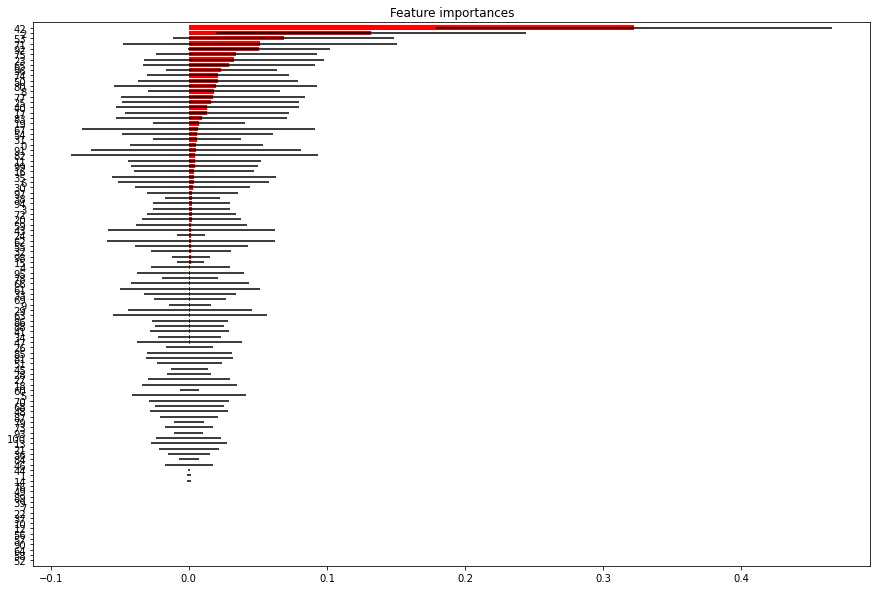

In [23]:
#We can then use this encoded data to train and evaluate the GBM classifier model, as before.
# fit model on training set
gbm_cls.fit(X_train_label, y_train)
# make prediction on test set
yhat = gbm_cls.predict(X_test_label)
#rounted_yhat = np.rint(np.array(yhat))
rounded_yhat = np.around(yhat)
rounded_yhat = rounded_yhat.astype(int)
# calculate accuracy
acc = accuracy_score(y_test, rounded_yhat)
print("The accuracy score (acc) on test set: {:.4f}".format(acc))
importances = gbm_cls.feature_importances_
std = np.std([tree.feature_importances_ for tree in np.ravel(gbm_cls.estimators_)],
             axis=0)
indices = np.argsort(importances)
# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.barh(range(X_train_label.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train_label.shape[1]), indices)
plt.ylim([-1, X_train_label.shape[1]])
plt.show()

The autoencoder with GBM classifier model seem to come to the same results with or without GBM model hyperparameter tunnings. The best hyperparameter settings with GBM regressor alone can do better than the combined autoencoder and GBM prediction model. But it is clear from feature importance plot that there are dimensions in gbm classfication model are more reduced than that GBM regression model using labels from autoencoder rmse. And therefore the performance of classification GBM is also better than regression, in par with that of that of not labelled. 

Histogram-Based Gradient Boosting Machine for Classification

The example below first evaluates a HistGradientBoostingClassifier on the test problem using repeated k-fold cross-validation and reports the mean accuracy. Then a single model is fit on all available data and a single prediction is made.

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
# evaluate the model
hgb_cls = HistGradientBoostingClassifier(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(hgb_cls, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#print(n_scores)
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
hgb_cls.fit(X_train, y_train)
# make a single prediction
yhat = hgb_cls.predict(X_test)
rounded_yhat = np.around(yhat)
rounded_yhat = rounded_yhat.astype(int)
acc = accuracy_score(y_test, rounded_yhat)
print("The accuracy score (acc) on test set: {:.4f}".format(acc))

In [ ]:
#We can then use this label column from autoencoding data to train and evaluate the HGB classifier model, as before.
# fit model on training set
hgb_cls.fit(X_train_label, y_train)
# make prediction on test set
yhat = hgb_cls.predict(X_test_label)
#rounted_yhat = np.rint(np.array(yhat))
rounded_yhat = np.around(yhat)
rounded_yhat = rounded_yhat.astype(int)
# calculate accuracy
acc = accuracy_score(y_test, rounded_yhat)
print("The accuracy score (acc) on test set: {:.4f}".format(acc))

The accuracy score (acc) on test set: 0.9273


XGBoost for Classification
The example below first evaluates an XGBClassifier on the test problem using repeated k-fold cross-validation and reports the mean accuracy. Then a single model is fit on all available data and a single prediction is made.

In [ ]:
# xgboost for classification
from numpy import asarray
from xgboost import XGBClassifier
# evaluate the model
xgb_cls = XGBClassifier(random_state=1, use_label_encoder=False)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(xgb_cls, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
xgb_cls.fit(X_train, y_train)
# make a single prediction
yhat = xgb_cls.predict(X_test)
rounded_yhat = np.around(yhat)
rounded_yhat = rounded_yhat.astype(int)
acc = accuracy_score(y_test, rounded_yhat)
print("The accuracy score (acc) on test set: {:.4f}".format(acc))

[17:37:24] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:24] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:24] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:37:24] WARNING: /Users/ktietz/demo/mc3/conda-bld/xg

In [ ]:
#We can then use this encoded data to train and evaluate the HGB classifier model, as before.
# fit model on training set
xgb_cls.fit(X_train_label, y_train)
# make prediction on test set
yhat = xgb_cls.predict(X_test_label)
#rounted_yhat = np.rint(np.array(yhat))
rounded_yhat = np.around(yhat)
rounded_yhat = rounded_yhat.astype(int)
# calculate accuracy
acc = accuracy_score(y_test, rounded_yhat)
print("The accuracy score (acc) on test set: {:.4f}".format(acc))

[17:37:53] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The accuracy score (acc) on test set: 0.9061


LightGBM for Classification
The example below first evaluates an LGBMClassifier on the test problem using repeated k-fold cross-validation and reports the mean accuracy. Then a single model is fit on all available data and a single prediction is made.

In [ ]:
# lightgbm for classification
from lightgbm import LGBMClassifier
# evaluate the model
lgbm_cls = LGBMClassifier(random_state=1)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(lgbm_cls, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
lgbm_cls.fit(X_train, y_train)
# make a single prediction
yhat = lgbm_cls.predict(X_test)
rounded_yhat = np.around(yhat)
rounded_yhat = rounded_yhat.astype(int)
acc = accuracy_score(y_test, rounded_yhat)
print("The accuracy score (acc) on test set: {:.4f}".format(acc))

Accuracy: 0.943 (0.021)
The accuracy score (acc) on test set: 0.9273


In [ ]:
#We can then use this encoded data to train and evaluate the HGB classifier model, as before.
# fit model on training set
lgbm_cls.fit(X_train_label, y_train)
# make prediction on test set
yhat = lgbm_cls.predict(X_test_label)
#rounted_yhat = np.rint(np.array(yhat))
rounded_yhat = np.around(yhat)
rounded_yhat = rounded_yhat.astype(int)
# calculate accuracy
acc = accuracy_score(y_test, rounded_yhat)
print("The accuracy score (acc) on test set: {:.4f}".format(acc))

The accuracy score (acc) on test set: 0.9273
